# Partial Pooling

<br/>[John Mount](https://win-vector.com/john-mount/)
<br/>[Win Vector LLC](https://win-vector.com) ([blog](https://win-vector.com/blog-2/))
<br/>4-2-2023


Much of data science is merely taking averages to estimate expected values. 

One can ask: are there better estimates for expected values than the obvious average of observations? One might think, in particular given the [Gauss Markov theorem](https://en.wikipedia.org/wiki/Gauss–Markov_theorem), the answer would have to be "no." Oddly enough, the answer is in fact "yes." One method to do this is called *partial pooling*, and we will describe this method here. There are even other methods, such as [James–Stein estimator](https://en.wikipedia.org/wiki/James–Stein_estimator) (which we do not go into here).

This note works an example of partial pooling from equation 12.1 of Gelman, Hill, "Data Analysis Using Regression and Multilevel/Hierarchical Models", Cambridge 2007. This is a bit of a magic trick, but we will show how it is done. I am not claiming this will revolutionize your data science projects, but it can be an improvement when you don't have a lot of data.

## Introduction

The topic of formula 12.1 is: how to partially pool data by hand, though this task is often handled by a hierarchical model solver. 

Take as our example problem: we want to estimate the ideal expected value of observed values from various locations. The optimal linear un-biased estimator is to just take the average of the observed values at each location, and hope this is close to the ideal unobserved generating process.

[Dr. Nina Zumel](https://win-vector.com/author/nzumel/) has two excellent articles on exactly this problem:

  * [Custom Level Coding in vtreat](https://win-vector.com/2017/09/25/custom-level-coding-in-vtreat/)
  * [Partial Pooling for Lower Variance Variable Encoding](https://win-vector.com/2017/09/28/partial-pooling-for-lower-variance-variable-encoding/)

These show how to use the right tools to perform and use the partial pooling analysis, largely in context of the `vtreat` data preparation system ([R version](https://CRAN.R-project.org/package=vtreat), [Python version](https://pypi.org/project/vtreat/)).

For this note, let's work on a formula and a synthetic example directly.

We will use `Python` and the `sympy` symbolic math package to work our examples. This is part of may "data for engineers" teaching effort, where we share code so people can try the methods. First we import our packages.

In [1]:
# import packages
import sympy
from sympy.stats import E, Normal
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Our problem set-up is:

  * Each location `j` has an unobserved expected value of examples drawn from this location, call this `LocationValue_j`.
  * The locations are related, in that the `LocationValue_j`s are all drawn from some common distribution. This is why we think pooling data could be useful, each location has a different value (but is telling us things about their common distribution).
  * Our observations are numbers drawn from a normal distribution around `LocationValue_j`. From these we hope to estimate `LocationValue_j`. The job is to try and remove the observation noise.
  * For a given location, we suspect that some combination of the observations from the location, *plus* observations from other locations may be a lower expected error estimate than can be found using only observations from the location. This is try to trade away some variance (the bane of small data situations) in place of accepting some bias in our procedures.

To execute this idea we need to define a great number of variables and their relations as follows.

In [2]:
# define initial variables
TrueEffectCenter = sympy.Symbol("TrueEffectCenter")  # center of distribution generating locations, unobserved
BetweenLocationsSD = sympy.Symbol("BetweenLocationsSD")  # how individual locations very from each other in expected behavior, unobserved
EstimatedEffectCenter = sympy.Symbol("EstimatedEffectCenter")  # estimate of TrueEffectCenter, observed but some issues how to calculate
LocationValue_j = sympy.Symbol("LocationValue_j")  # actual expected behavior of a given location, unobserved and the goal to estimate
LocationDistFactor_j = Normal("LocationDistFactor_j", mean=0, std=BetweenLocationsSD)  # how locations differ from each other, unobserved
def_LocationValue_j = TrueEffectCenter + LocationDistFactor_j  #  generative definition of LocationDistFactor_j
PerObservationSD = sympy.Symbol("PerObservationSD", positive=True)  # sd of distribution generating observations per location, unobserved
n_j = sympy.Symbol("n_j", positive=True)  # number of observations at the j-th location, observed
LocationMean_j = sympy.Symbol("LocationMean_j", mean=LocationValue_j, std=PerObservationSD)  # mean of all observations at location j, observed
LocationCenterNoise_ji = Normal("LocationCenterNoise_ji", mean=0, std = PerObservationSD / sympy.sqrt(n_j))  # distribution of average seen at location j, unobserved
def_LocationMean_j = LocationValue_j + LocationCenterNoise_ji  # generative definition of LocationCenterNoise_ji
w = sympy.Symbol("w", positive=True)  # our weighting term picking how to pool specific and general observations, to solve for
estimate_j = sympy.Symbol("estimate_j")  # our estimate of the behavior of the j-th location, to solve for


These are a lot of terms, but most of them are merely placeholders for our calculations. The trickiest term is `LocationCenterNoise_ji` which is correct for independent observations. `LocationCenterNoise_ji` is founded on the fact that variance is additive for independent observations. The `Normal()` could be relaxed a bit, but it appears we must specify some specific distribution to use `sympy`'s expectation operators `E()`. If we can't use `E()` we could simulate it with more guided substitution steps. Throughout this analysis we are assuming our random variables are independent.

Our goal is to pick a `estimate_j` to minimize the expected square of the following expression.

In [3]:
expected_error_term = LocationValue_j - estimate_j  # error of our estimate, to minimize square of

expected_error_term

LocationValue_j - estimate_j

Our plan is to re-factor this expression into independent expectation zero terms `A`, `B` and then use the fact that for such terms `E[(A - B_**2)] = E[A**2] + E[B**2]`. The goal is to derive relation 12.1 from Gelman and Hill:



<img src="IMG_1323.png">

This is a big equation with a "pooling strength" coefficient expanded into the expression. If we write the pooling coefficient as `w`, we can then re-write the above as the following.

In [4]:
def_estimate_j = w * LocationMean_j + (1-w) * EstimatedEffectCenter  # definition of our estimate

def_estimate_j

EstimatedEffectCenter*(1 - w) + LocationMean_j*w

That is: our estimate is `w` times using the observed per-location mean (`LocationMean_j`, the obvious estimate) plus `(1-w)` times average expected behavior over all locations. Setting `w = 1` gives us the traditional "use only observations from the chosen location" solution. Setting `w = 0` gives us complete pooling, assuming there is no difference between locations. The trick is to find a `w` between `0` and `1` that might have lower expected square error. 

The 12.1 estimate is a solution that picks `w` as the following.

In [5]:
neat_soln_approx = 1 / (1 + PerObservationSD**2 / (n_j * BetweenLocationsSD**2))

neat_soln_approx

1/(1 + PerObservationSD**2/(BetweenLocationsSD**2*n_j))

Some algebra shows this is the same as the Gelman and Hill citation (if we adopt the convention that `w = 0` when `n_j = 0`). We confirm that as follows.

In [6]:
GH_soln =(n_j / PerObservationSD**2) / ( n_j / PerObservationSD**2 + 1 / BetweenLocationsSD**2)
assert (neat_soln_approx - GH_soln).together() == 0

This solution for `w` has some nice properties.

  * `w` goes to `1` (the standard simple solution) as `PerObservationSD` goes to zero. This can be read as: "there is no point in pooling of their is already little uncertainty in the obvious estimate.
  * `w` goes to `1` (the standard simple solution) as `n_j` goes to infinity. This can be read as: "there is no point in pooling if we already have a lot of data for the obvious estimate."
  * `w` goes to `0` (combining all the data) as `n_j` goes to zero (using the convention `1/infinity = 0`). This can be read as: "with no data for a new location, use the grand average."
  * `w` goes to `0` (combining all the data) as `PerObservationSD` goes to infinity. This can be read as: "combine all the data if the per-location uncertainty is very high."


Our goal is to derive this solution.


## Reproducing the Gelman and Hill citation

We can match the Gelman and Hill citation by, during the solving, replacing the visible `TrueEffectCenter` with our estimated `EstimatedEffectCenter` (ignoring an an assumed small difference between them).

When we solve in that manner we get the Gelman and Hill cited `w` as follows. Let's work on that error term, that we want to minimize the expected square of, for a bit.

In [7]:
error_term_approx = (
    expected_error_term
        .subs(estimate_j, def_estimate_j)  # definition of estimate_j
        .subs(EstimatedEffectCenter, TrueEffectCenter)  # this step is an approximation, using the unobserved TrueEffectCenter as if it is the observed EstimatedEffectCenter
        .subs(LocationMean_j, def_LocationMean_j)  # generative definition of LocationMean_j
        .subs(LocationValue_j, def_LocationValue_j)   # generative definition of LocationValue_j
).expand().simplify()

error_term_approx

-w*LocationCenterNoise_ji - w*LocationDistFactor_j + LocationDistFactor_j

The simplifying substitution `MeanLocation` value for the `EstimatedEffectCenter` is an approximation, and is why the total number of observations is not present in this estimate. This substitution is ignoring the uncertainty in estimating the grand mean, which we assume is slightly easier than our overall task of estimating the conditional means. Or a different view would be: if we felt we knew `MeanLocation` this is how we would perform the estimate. For example in re-encoding variables (such as in `vtreat`) we know the overall `MeanLocation` is in fact zero by the structure of the application set-up.

There is in fact an issue in how to estimate `EstimatedEffectCenter` when different locations have very different numbers of observations. In this case an average where each observation contributes equally is sensitive to the between location variances, and an average where each location contributes equally is sensitive to per observation variances. What to put in for `EstimatedEffectCenter` is essentially the entire estimation problem started over again, so picking the data weighting cleverly probably is of some benefit.

Assuming we were happy with what we plugged in for `EstimatedEffectCenter` we can continue our calculation as follows.

We claim this error term is equal to `A - B`, for the following `A`, `B`.

In [8]:
A = (1-w) * LocationDistFactor_j
B = w * LocationCenterNoise_ji

And we can confirm this claim as follows.

In [9]:
assert (error_term_approx - (A - B)).simplify() == 0
assert E(A).expand() == 0
assert E(B).expand() == 0

We can expand the expected square error `E[(A - B)**2]` as `E[A**2] + E[B**2]` (using the independence of `A` and `B`, and that they are both expected value zero).

We expect the minimum to occur at either the bounds of our allowed values for `w` (`0` and `1`) or at a place where the derivative of our expected square error term with respect to `w` is zero. That solution is found as follows.

In [10]:
soln_approx = sympy.solve(sympy.diff(E(A**2) + E(B**2), w), w)[0]

soln_approx

BetweenLocationsSD**2*n_j/(BetweenLocationsSD**2*n_j + PerObservationSD**2)

And we confirm this is (for non-zero quantities) equivalent to the earlier claimed solution.

In [11]:
assert (soln_approx - neat_soln_approx).together().expand() == 0

And this, as promised, matches the text book. 

I am experimenting more and more with using `sympy` in place of hand-worked algebra in these sort of write-ups. My hope is that it allows me to spend more time on intent, and less time explaining steps (which often introduced yet more steps).

## Working an Example

Let's see the partial pooling inference in action. 

We will generate the synthetic example data according to the above hierarchical design. We will then see how a pooled estimate, itself using estimate parameters, can in fact improve estimation results. The advantage of synthetic data include: we can see how close the estimates come to the correct answers, and we can generate a favorable situation for demonstration.

We generate the not directly observable portion of our example as follows.

In [12]:
# set state of pseudo random number generator for repeatability
rng = np.random.default_rng(2023)  

In [13]:
# set parameters to specific values
example_between_locations_sd = 3.0
example_per_observations_sd = 10.0
n_locations = 10
n_obs_per_location = list(range(1, 5))

In [14]:
def generate_example_centers() -> pd.DataFrame:
    """generate the unobserved location values"""
    example_location_value_mean = rng.normal(loc=0, scale=15, size=1)
    example_locations = pd.DataFrame({
        "location_id": range(n_locations),
        "effect": rng.normal(
        loc=example_location_value_mean, 
        scale=example_between_locations_sd, 
        size=n_locations)
    })
    return example_locations

In [15]:
example_locations = generate_example_centers()

In [16]:
example_locations

,location_id,effect
0,0,12.480676
1,1,4.947432
2,2,9.691985
3,3,6.698217
4,4,11.451937
5,5,8.429935
6,6,4.289738
7,7,7.137952
8,8,7.862549
9,9,9.176378


And we can then generate observations as follows.

In [17]:
def generate_observations(example_locations: pd.DataFrame)-> pd.DataFrame:
    """
    generate observed data

    :param example_locations: the (unobserved) ground truth to generate from
    :return: observed data
    """
    assert isinstance(example_locations, pd.DataFrame)
    observations = []
    for j in range(example_locations.shape[0]):
        obs_j = pd.DataFrame({
            "location_id": j,
            "observation": rng.normal(
            loc=example_locations.effect[j], 
            scale=example_per_observations_sd, 
            size=rng.choice(n_obs_per_location, size=1)[0],
            ),
        })
        observations.append(obs_j)
    observations = pd.concat(observations, ignore_index=True)
    return observations


In [18]:
observations = generate_observations(example_locations)

In [19]:
observations

,location_id,observation
0,0,13.802057
1,0,26.529701
2,1,8.988453
3,1,-5.426702
4,1,-2.470594
5,1,17.582427
6,2,16.772133
7,2,9.341510
8,3,-1.679948
9,3,-0.626963


Now we define the standard estimator, and code to evaluate how well it estimates the first group's expected value.

In [20]:
# define the standard estimator
def standard_effect_estimate(observations: pd.DataFrame) -> pd.DataFrame:
    """
    Get the standard estimate of the effect at locations from observations.
    Please see: https://github.com/WinVector/Examples/blob/main/PartialPooling/PartialPooling.ipynb

    :param observations: the observations data frame
    :return: standard estimate of effect or mean by location
    """
    assert isinstance(observations, pd.DataFrame)
    means = (
        observations.loc[:, ["location_id", "observation"]]
        .reset_index(drop=True, inplace=False)
        .groupby(["location_id"])
        .agg(['mean', 'var', 'size'])
        .reset_index(drop=False, inplace=False)
    )
    cols = [' '.join(col).strip() for col in means.columns]
    means.columns = [c.removeprefix('observation ') for c in cols]
    means.sort_values(["location_id"], inplace=True, ignore_index=True)
    means['estimate'] = means['mean']
    means["grand_mean"] = np.mean(observations["observation"])
    means["impact"] = means["estimate"]
    means["impact"] = (
        means["impact"] 
        - np.sum(means['size'] * means['impact']) / np.sum(means['size']))
    means.sort_values(["location_id"], inplace=True, ignore_index=True)
    return means

The standard estimate works as follows.

In [21]:
standard_effect_estimate(observations)

,location_id,mean,var,size,estimate,grand_mean,impact
0,0,20.165879,80.996461,2,20.165879,6.845746,13.320134
1,1,4.668396,112.770421,4,4.668396,6.845746,-2.177350
2,2,13.056822,27.607078,2,13.056822,6.845746,6.211076
3,3,-1.153455,0.554389,2,-1.153455,6.845746,-7.999201
4,4,9.902428,197.235285,3,9.902428,6.845746,3.056682
5,5,6.004170,94.294674,2,6.004170,6.845746,-0.841576
6,6,6.942103,95.833984,3,6.942103,6.845746,0.096358
7,7,0.016030,161.807194,4,0.016030,6.845746,-6.829716
8,8,-12.981490,NaN,1,-12.981490,6.845746,-19.827236
9,9,13.099624,69.122322,4,13.099624,6.845746,6.253878


In [22]:
# estimate the quality of the standard estimator
def get_sq_error_loss_std_estimate(
        *, 
        location_id: int, example_locations: pd.DataFrame, observations: pd.DataFrame) -> float:
    """
    Show the square-error of estimate of the effect at location location_id from observations

    :parm location_id: which location to calculate for
    :param example_locations: the (unobserved) ground truth to compare to
    :param observations: the observations data frame
    :return: estimated square error of this estimation procedure
    """
    # get the standard estimates
    observed_means = standard_effect_estimate(observations=observations)
    # get the unobservable true effect for comparison
    true_effect = example_locations.loc[example_locations["location_id"] == location_id, "effect"].values[0]
    # calculate the square error of these estimates
    estimated_effect = observed_means.loc[observed_means["location_id"] == location_id, "estimate"].values[0]
    square_error = (estimated_effect - true_effect)**2
    return square_error


And we define the pooled estimator, and it's evaluation procedure.

In [23]:
# define the pooled estimator
def pooled_effect_estimate(observations: pd.DataFrame) -> pd.DataFrame:
    """
    Get the pooled estimate of effect.
    See: https://github.com/WinVector/Examples/blob/main/PartialPooling/PartialPooling.ipynb .

    :param observations: the observations data frame, with columns location_id and observation
    :return: pooled estimates
    """
    assert isinstance(observations, pd.DataFrame)
    observations = observations.loc[:, ["location_id", "observation"]].reset_index(
        inplace=False, drop=True
    )
    # get the standard estimates
    estimated_centers = standard_effect_estimate(observations=observations)
    grand_var = np.var(observations['observation'])
    if (estimated_centers.shape[0] <= 1) or pd.isnull(grand_var) or (grand_var <= 0):
        # no pooling possible
        return estimated_centers
    # get counts per group
    n_j = estimated_centers["size"]
    per_location_observation_var = estimated_centers['var'].copy()
    per_location_observation_var[pd.isnull(per_location_observation_var)] = 0
    # inflate per-loc a bit
    per_location_observation_var = (
        (n_j * per_location_observation_var + grand_var)
        / (n_j + 1))
    # get the observed variance between locations
    between_location_var = np.var(estimated_centers["estimate"], ddof=1)
    # get v, the pooling coefficient
    if between_location_var <= 0:
        v = 0 * per_location_observation_var
    else:
        # as between_location_var > 0 and per_location_observation_var > 0 here
        # v will be in the range 0 to 1
        v = 1 / (1 + per_location_observation_var / (n_j * between_location_var))
    v[pd.isnull(v)] = 0
    # build the pooled estimate
    pooled_estimate = v * estimated_centers["estimate"] + (1 - v) * estimated_centers["grand_mean"]
    estimated_centers["estimate"] = pooled_estimate
    estimated_centers["impact"] = estimated_centers["estimate"] 
    estimated_centers["impact"] = (
        estimated_centers["impact"] 
        - np.sum(estimated_centers['size'] * estimated_centers['impact']) / np.sum(estimated_centers['size']))
    return estimated_centers

The pooled estimate works as follows.

In [24]:
# show the estimate in action
pooled_effect_estimate(observations)

,location_id,mean,var,size,estimate,grand_mean,impact
0,0,20.165879,80.996461,2,15.457382,6.845746,8.564178
1,1,4.668396,112.770421,4,5.213367,6.845746,-1.679837
2,2,13.056822,27.607078,2,11.488942,6.845746,4.595739
3,3,-1.153455,0.554389,2,0.351447,6.845746,-6.541756
4,4,9.902428,197.235285,3,8.650058,6.845746,1.756854
5,5,6.004170,94.294674,2,6.319379,6.845746,-0.573825
6,6,6.942103,95.833984,3,6.914757,6.845746,0.021553
7,7,0.016030,161.807194,4,2.132592,6.845746,-4.760612
8,8,-12.981490,NaN,1,-4.895610,6.845746,-11.788813
9,9,13.099624,69.122322,4,11.924881,6.845746,5.031678


In [25]:
# evaluate the pooled estimator quality
def get_sq_error_loss_pooled_estimate(
        *, 
        location_id: int, example_locations: pd.DataFrame, observations: pd.DataFrame) -> float:
    """
    Show the square error of partial pooled out estimates of the effect at location location_id from observations

    :parm location_id: which location to calculate for
    :param example_locations: the (unobserved) ground truth to compare to
    :param observations: the observations data frame
    :return: estimated square error of this estimation procedure
    """
    # get the estimates
    pooled_estimates = pooled_effect_estimate(observations=observations)
    # get the unobservable true effect for comparison
    true_effect = example_locations.loc[example_locations["location_id"] == location_id, "effect"].values[0]
    # calculate the square error of these estimates
    estimated_effect = pooled_estimates.loc[pooled_estimates["location_id"] == location_id, "estimate"].values[0]
    square_error = (estimated_effect - true_effect)**2
    return square_error

Now, let's try the estimators. In each case we the evaluation is returning square-error, so smaller is better.

In [26]:
# run the experiment for the standard estimator
std_est_loss = get_sq_error_loss_std_estimate(
    location_id=0, 
    example_locations=example_locations, 
    observations=observations)

std_est_loss

59.062343664162356

In [27]:
# run the experiment for the pooled estimator
pooled_est_loss = get_sq_error_loss_pooled_estimate(
    location_id=0, 
    example_locations=example_locations, 
    observations=observations)

pooled_est_loss

8.860775473223525

In [28]:
assert pooled_est_loss < std_est_loss  # not always true, due to higher variance on std est (and just randomness!)

We see, the pooled estimate has smaller expected square error loss that the standard estimate. That is: we have evidence the pooled estimate would be closer to new observations for a given location. We want to further confirm by repeating the experiment more times.

In [29]:
# wrap our experiment in a repeatable function
def run_experiment() -> pd.DataFrame:
    example_locations = generate_example_centers()
    observations = generate_observations(example_locations)
    std_est_loss = get_sq_error_loss_std_estimate(
        location_id=0, 
        example_locations=example_locations, 
        observations=observations)
    pooled_est_loss = get_sq_error_loss_pooled_estimate(
        location_id=0, 
        example_locations=example_locations, 
        observations=observations)
    return pd.DataFrame({
        "std_loss": [std_est_loss],
        "pooled_loss": [pooled_est_loss],
    })

In [30]:
# run the experiments
experiments = pd.concat([run_experiment() for i in range(1000)], ignore_index=True)

In [31]:
# show the average loss of each method
experiments.mean()

std_loss       50.370861
pooled_loss    23.940735
dtype: float64

In [32]:
# show the median loss of each method
medians = experiments.median()
medians

std_loss       20.661076
pooled_loss     9.557316
dtype: float64

In [33]:
# show how each method's loss varies (standard deviation)
experiments.std()

std_loss       82.313274
pooled_loss    39.233761
dtype: float64

Notice the pooled method, in this example, out-performs the standard method in all three of the above measurements. This is because the example is deliberately generating closely related data. 

We can also plot the distribution losses to get a bit more detail.

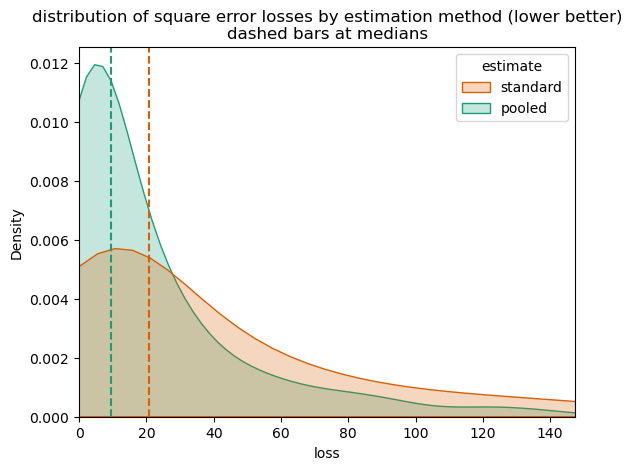

In [34]:
# plot the experiments
plt_frame = pd.concat([
    pd.DataFrame({"estimate": "standard", "loss": experiments["std_loss"]}),
    pd.DataFrame({"estimate": "pooled", "loss": experiments["pooled_loss"]}),
    ], ignore_index=True)
palette = ["#d95f02", "#1b9e77"]
sns.kdeplot(
    data=plt_frame,
    x="loss",
    hue="estimate",
    hue_order=["standard", "pooled"],
    palette=palette,
    fill=True,
)
plt.title("distribution of square error losses by estimation method (lower better)\ndashed bars at medians")
plt.xlim(0, np.quantile(plt_frame["loss"], 0.95))
plt.axvline(x=medians["std_loss"], color=palette[0], linestyle="dashed")
plt.axvline(x=medians["pooled_loss"], color=palette[1], linestyle="dashed")
plt.show()

The method has been seen to work, even with estimated variances and grand means (instead of using the unobserved true generating parameters). This is evidence the method can be used in practice.

# A note on hierarchical models

We've not really talked about the meaning of the term "hierarchical model."

Hierarchical models are the clear way to explain the how different data generation assumptions effect our modeling strategy. In this case, knowing how strongly different data is related allows us to implement a lower variance (though biased) estimate. This note is the direct re-implementation of a simple hierarchical model: using that locations come from a common distribution, and then later produce observations.

From Gelman and Hill section 11.3 we take that hierarchical models are an alternative to attempts to define *fixed effect* versus *random effect* modeling. We understand this is from Bayesian-friendly authors that don't particularly like the Frequentist terms *fixed effect* and *random effect*, but their advice seems sound:

> Our advice (elaborated upon in the rest of this book) is to *always* use multilevel modeling ("random effects"). Because of conflicting definitions and advice, we avoid the terms "fixed" and "random" entirely, and focus on the description of the model itself [...] with the understanding that batches of coefficients [...] will themselves be modeled.

(Ellipses meant to avoid some un-introduced detail, and not alter the meaning, context, or scope of the original statement. In this context "modeled" essentially means subject to distributional assumptions, be these assumptions priors or conditions relating groups of variables. This is quite normal for Bayesians. But needs to be mystified a bit when used by Frequentists, as this is something Frequentists claim not to do.)



## Conclusion

The partial pooling improvement for estimating an unseen value from noisy observations depends on a single parameter `PerObservationSD**2 / (n_j * BetweenLocationsSD**2)`. This parameter compares the uncertainty in the mean of the observations (`PerObservationSD**2 / n_j`, or standard error squared) for a single location, to the uncertainty between locations (`BetweenLocationsSD**2`, a standard deviation squared). When this ratio is small, we don't pool data, we just estimate the average value using data from one location. When this ratio is large, pooling is likely a useful variance reducing procedure. Of course, these values are not directly observed; and thus have to be themselves estimated.

Essentially the partial pooling method is trading away variance (due to having very few samples) for bias (due to including samples that don't match the target location). If the different locations are sufficiently related, this can be an improving trade off in terms of expected square error.

In practice, all of the above is typically ignored when there is a lot of data. And, the above inference is made inside a hierarchical model solver, not directly by a practitioner. However, it is good to see the actual form of the pooling strategy.